# RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

## Read the data first

In [30]:
from nb_utils import read_commits, SAFETENSORS_RELEASE_DATE

# frame listing model files per repository and commits as well as with the elapsed days between the commit and safetensor's release date
df = read_commits()

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']

# Group by elapsed days to count files modified on each date
# files_modified_by_elapsed_days = df_safetensors['elapsed_days'].value_counts().sort_index()

# Group by date and count the number of files modified on that date
# files_modified_by_date = df_safetensors['date'].value_counts().sort_index()

# find the lowest number of elapsed days per unique repo_url 
# (ie, when safetensors first appeared in each repo)
df_safetensors_first_appearance = df_safetensors.copy().groupby('repo_url')['elapsed_days'].min()
df_safetensors_first_appearance = df_safetensors_first_appearance.reset_index()

## Analysis 1: How many commits containing safetensors files were made by the SFconvertbot?

HuggingFace has a bot (https://huggingface.co/SFconvertbot) that converts models to safetensors.
How many commits were made by the bot and how many were made by developers themselves?
Hugging Face bot's source code: https://github.com/huggingface/safetensors/commits/main/bindings/python/convert.py

In [34]:
bot_message = "Adding `safetensors` variant of this model"
df_safetensors_not_by_bot = df_safetensors[~df_safetensors['message'].str.contains(bot_message)]
df_safetensors_by_bot = df_safetensors[df_safetensors['message'].str.contains(bot_message)]

num_commits = len(df['commit_hash'].unique())
num_safetensors_commits = len(df_safetensors['commit_hash'].unique())
num_safetensors_commits_by_bot = len(df_safetensors_by_bot['commit_hash'].unique())
num_safetensors_commits_not_by_bot = len(df_safetensors_not_by_bot['commit_hash'].unique())

print(f"# commits: {num_commits}")
print(f"# commits touching safetensor files: {num_safetensors_commits}")
print(f"% commits made by the bot: {num_safetensors_commits_by_bot / num_safetensors_commits * 100:.1f}% ({num_safetensors_commits_by_bot})")
print(f"% commits made by developers: {num_safetensors_commits_not_by_bot / num_safetensors_commits * 100:.1f}% ({num_safetensors_commits_not_by_bot})")


# commits: 4542
# commits touching safetensor files: 473
% commits made by the bot: 84.6% (400)
% commits made by developers: 15.4% (73)


## Analysis 2: Number of elapsed days since the release of safetensors

This script checks how long it took safetensors to first appear in each analyzed repository.

In [33]:
min = df_safetensors_first_appearance['elapsed_days'].min()
max = df_safetensors_first_appearance['elapsed_days'].max()
median = df_safetensors_first_appearance['elapsed_days'].median()
quartile2 = df_safetensors_first_appearance['elapsed_days'].quantile(0.25)
quartile4 = df_safetensors_first_appearance['elapsed_days'].quantile(0.75)
# count number of repos without safetensors
print("Number of analyzed repos: ", len(df['repo_url'].unique()))
print(f"Number of repos without safetensors: {len(df['repo_url'].unique()) - len(df_safetensors_first_appearance)}")
print("Number of repos using safe tensors", len(df_safetensors_first_appearance))
print("min, quartile2, median, quartile4, max=",min, quartile2, median, quartile4, max)

Number of analyzed repos:  1028
Number of repos without safetensors: 612
Number of repos using safe tensors 416
min, quartile2, median, quartile4, max= 6 224.0 512.5 551.0 733


## Analysis 3: Plot the number of adoptions per elapsed days

Since the first safetensors release, shows the number of model files using safetensors per elapsed days.

169.84165887577626


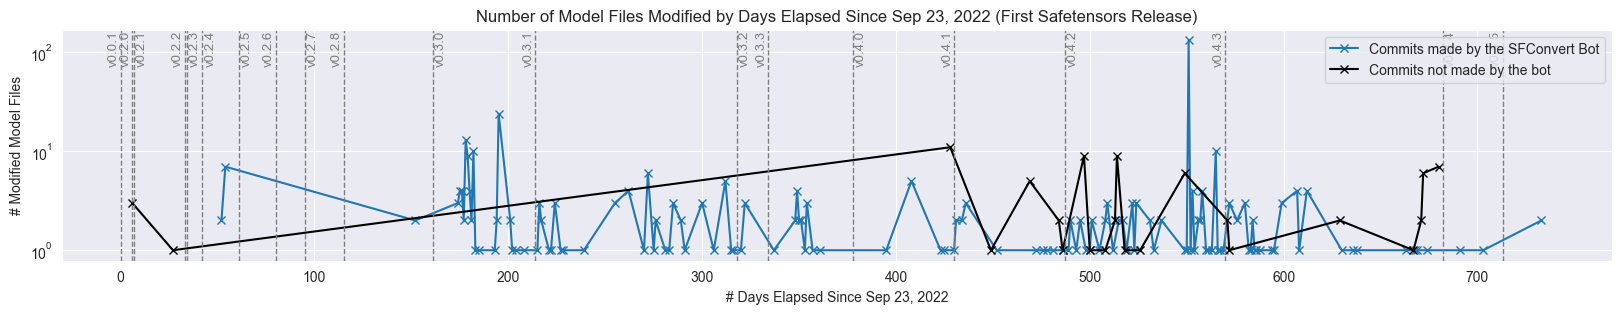

In [92]:
from pathlib import Path
import matplotlib.pyplot as plt
from nb_utils import get_safetensors_releases, SAFETENSORS_RELEASE_DATE

# Group by elapsed days to count files modified on each date
all_commits = df_safetensors['elapsed_days'].value_counts().sort_index()
commits_not_by_bot = df_safetensors_not_by_bot['elapsed_days'].value_counts().sort_index()
commits_by_bot = df_safetensors_by_bot['elapsed_days'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(20,3))
plt.plot(commits_by_bot.index, commits_by_bot.values, marker='x', linestyle='-', label="commits by bot")
plt.plot(commits_not_by_bot.index, commits_not_by_bot.values, marker='x', linestyle='-',color='black',  label="commits not by bot")
plt.xlabel("# Days Elapsed Since Sep 23, 2022")
plt.ylabel("# Modified Model Files")
plt.title("Number of Model Files Modified by Days Elapsed Since Sep 23, 2022 (First Safetensors Release)")
plt.yscale('log')
plt.grid(True)


df_releases  = get_safetensors_releases()

#  add vertical lines for each release date with labels
colors = ['tab:gray', 'tab:gray']
positions = [0.99, 0.99]
i = 0
x_coordinates = [1, -6.5]
ymax = 0.00001
step = 0.05
print(plt.ylim()[1])
for day, label in df_releases[['date', 'tag']].values:
    i = (i + 1) % 2
    diff = (day - SAFETENSORS_RELEASE_DATE).days
    plt.axvline(x=diff,color='tab:gray', linestyle='--', linewidth=1)
    
    if label == 'v0.2.4': 
        plt.text(diff +1.5, plt.ylim()[1] * positions[i], label, color='tab:gray', rotation=90, verticalalignment='top', fontdict={'size':9.5})
    else:
        plt.text(diff + x_coordinates[i], plt.ylim()[1] * positions[i], label, color='tab:gray', rotation=90, verticalalignment='top', fontdict={'size':9.5})
    if label == 'v0.0.1': i = 2
    

plt.legend(('Commits made by the SFConvert Bot','Commits not made by the bot'),loc="best")

# Save the plot as a PDF file
plt.savefig(Path('../../results/RQ1SafetensorsAdoption.pdf'), format="pdf", bbox_inches="tight")

plt.show()




